In [95]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
np.random.seed(42) 

## **Diabetes Prediction Dataset**
Le dataset Kaggle sur la prédiction du diabète contient des données cliniques permettant de prédire si un patient est diabétique ou non.

Les variables communes comprennent souvent :

- **gender** : Sexe du patient (Female/Male)
- **hypertension** : Hypertension (0 = non, 1 = oui)
- **heart_disease** : Maladie cardiaque (0 = non, 1 = oui)
- **smoking_history** : Historique tabagique, avec plusieurs catégories dont 'never', 'current', 'No Info', etc.
- **age** : Âge en années
- **bmi** : Indice de masse corporelle
- **HbA1c_level** : Taux d’hémoglobine glyquée
- **blood_glucose_level** : Niveau de glucose sanguin
- **diabetes** : la variable cible (0 = non diabétique, 1 = diabétique)

## Chargement du dataset et Exploration des données

In [33]:
dataset = pd.read_csv("diabetes_prediction_dataset.csv")

In [15]:
# j'affiche quelque ligne de données
dataset.head(8)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0


In [16]:
#j'affiche des informations sur les données
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [17]:
dataset.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [18]:
# j'affiche les statistiques pour les variables categorielles
dataset.describe(include='object')

,gender,smoking_history
count,100000,100000
unique,3,6
top,Female,No Info
freq,58552,35816


In [19]:
#analyse de la variable gender
gender_modalite = dataset['gender'].value_counts()
gender_modalite

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

In [20]:
#analyse de la variable smoking_history
smoking_history_mod = dataset['smoking_history'].value_counts()
smoking_history_mod

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

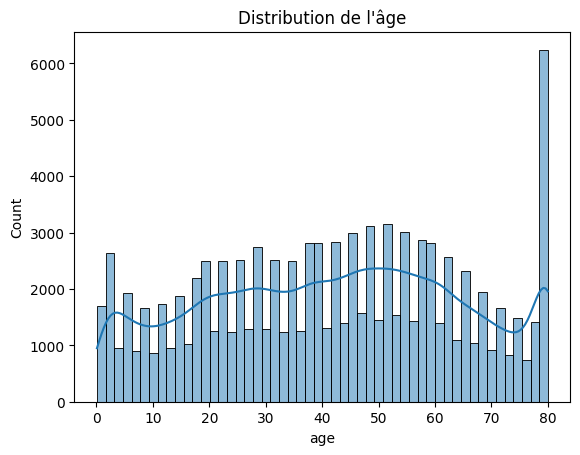

In [22]:
#distribution de l'age
sns.histplot(dataset['age'], kde=True)
plt.title("Distribution de l'âge")
plt.show()

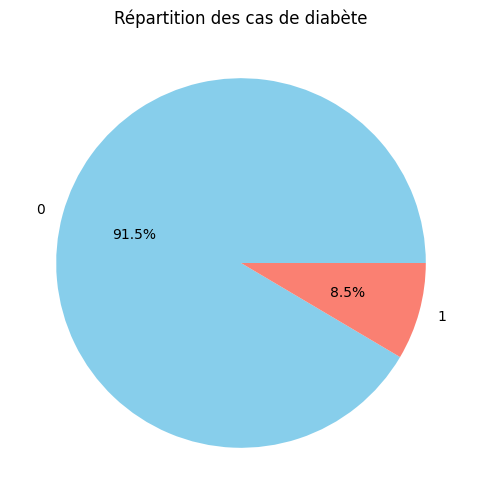

In [25]:
# distribution de la variable cible
plt.figure(figsize=(6,6))
dataset['diabetes'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'salmon'])
plt.title("Répartition des cas de diabète")
plt.ylabel("")
plt.show()

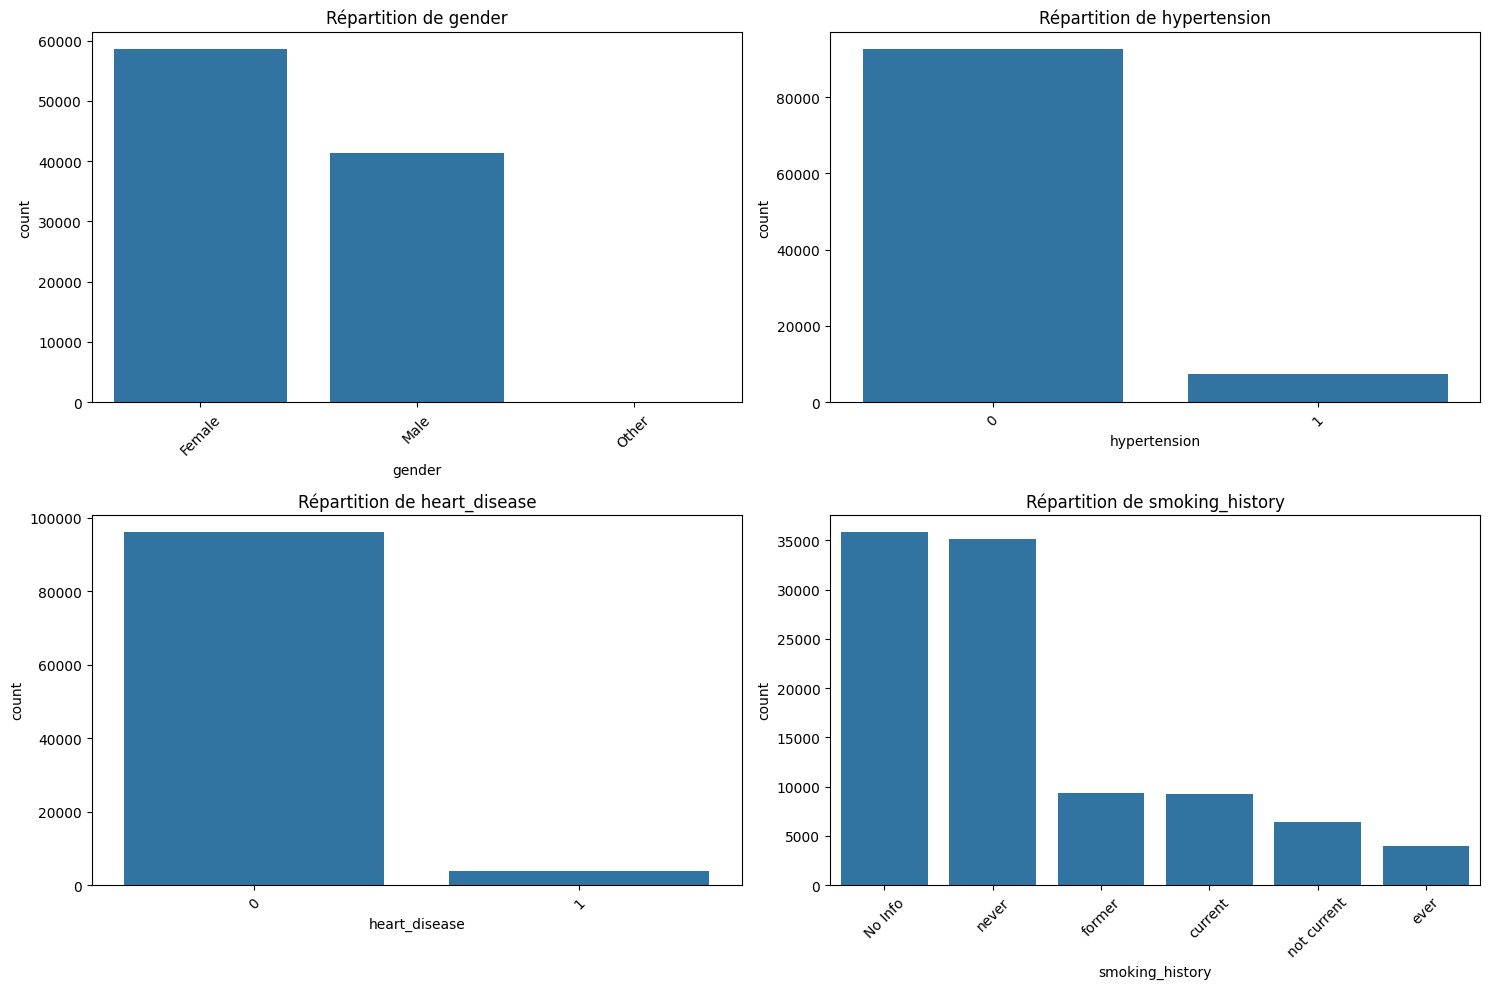

In [27]:
# Répartition des catégories dans les variables catégorielles
cat_vars = ['gender', 'hypertension', 'heart_disease', 'smoking_history']
plt.figure(figsize=(15,10))

for i, var in enumerate(cat_vars, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=dataset, x=var, order=dataset[var].value_counts().index)
    plt.title(f"Répartition de {var}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### **Interprétations générales**
- Le dataset contient 100 000 observations avec 9 variables incluant des facteurs de risque du diabète.
- Aucune valeur manquante, ce qui facilite l'analyse.
- L'âge moyen est de 41,9 ans avec une large distribution. Les niveaux moyens de HbA1c (5,53%) et glucose (138 mg/dL) suggèrent une population avec des valeurs proches des seuils diabétiques.
- Pour la distribution de l'âge, est une distribution bimodale avec un pic majeur vers 80 ans et une distribution plus étalée entre 20-60 ans, suggérant deux populations distinctes dans l'échantillon.
- Seulement 8,5% de diabétiques dans l'échantillon, indiquant un dataset déséquilibré avec une forte majorité de non-diabétiques (91,5%).
- la répartition des catégories dans les variables catégorielles informe que la majorité sont des femmes, très peu d'hypertendus, quasi-absence de maladies cardiaques, et une répartition variée des habitudes tabagiques.

## Prétraitement

#### Prétraitement effectué
- 
- **Encodage des variables catégorielles**, parceque les modeles comme la régression logistique, KNN, SVM et d'autres ne comprennet que des nombres, pas des chaînes de caractères.
- **La standardisation des données** pour les mettre centrées en 0 avec un écart-type de 1, parceque certaines variables numériques (comme Fare) ont des valeurs très grandes, d'autres (comme Pclass) des valeurs petites. Cela peut perturber certains modèles, en particulier ceux qui utilisent des distances ou des gradients.

In [41]:
# encoder les variables categorielles
# création des encodeurs
gender_encoder = LabelEncoder()
smoking_history_encoder = LabelEncoder()

# encodage et sauvegarde
dataset['gender'] = gender_encoder.fit_transform(dataset['gender'])
dataset['smoking_history'] = smoking_history_encoder.fit_transform(dataset['smoking_history'])
# N.B que LabelEncoder trie d'abord les valeurs avant qu'il encode

# standardiser les données numériques
scaler1 = StandardScaler()
scaler2 = StandardScaler()
scaler3 = StandardScaler()
scaler4 = StandardScaler()

dataset[['age']] = scaler1.fit_transform(dataset[['age']])
dataset[['bmi']] = scaler2.fit_transform(dataset[['bmi']])
dataset[['HbA1c_level']] = scaler3.fit_transform(dataset[['HbA1c_level']])
dataset[['blood_glucose_level']] = scaler4.fit_transform(dataset[['blood_glucose_level']])


In [42]:
# j'affiche quelque ligne de données
dataset.head(8)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1.692704,0,1,4,-0.321056,1.001706,0.047704,0
1,0,0.538006,0,0,0,-0.000116,1.001706,-1.426210,0
2,1,-0.616691,0,0,4,-0.000116,0.161108,0.489878,0
3,0,-0.261399,0,0,1,-0.583232,-0.492690,0.416183,0
4,1,1.515058,1,1,1,-1.081970,-0.679490,0.416183,0
5,0,-0.971982,0,0,4,-0.000116,1.001706,-1.303384,0
6,0,0.093892,0,0,4,-1.207032,0.908306,1.521618,1
7,0,1.648292,0,0,0,-0.521455,0.161108,-1.303384,0


In [43]:
dataset.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,1.000000e+05,100000.00000,100000.000000,100000.000000,1.000000e+05,1.000000e+05,1.000000e+05,100000.000000
mean,0.414660,1.447553e-16,0.07485,0.039420,2.179650,-1.729816e-16,-3.410605e-18,-2.786749e-16,0.085000
std,0.493031,1.000005e+00,0.26315,0.194593,1.889659,1.000005e+00,1.000005e+00,1.000005e+00,0.278883
min,0.000000,-1.856658e+00,0.00000,0.000000,0.000000,-2.608320e+00,-1.893686e+00,-1.426210e+00,0.000000
25%,0.000000,-7.943364e-01,0.00000,0.000000,0.000000,-5.561106e-01,-6.794897e-01,-9.349053e-01,0.000000
50%,0.000000,4.948073e-02,0.00000,0.000000,3.000000,-1.155837e-04,2.545078e-01,4.770422e-02,0.000000
75%,1.000000,8.044750e-01,0.00000,0.000000,4.000000,3.404125e-01,6.281067e-01,5.144437e-01,0.000000
max,2.000000,1.692704e+00,1.00000,1.000000,5.000000,1.030161e+01,3.243300e+00,3.978142e+00,1.000000


### Séparation train/test 

In [44]:
X = dataset.drop(columns=['diabetes'])
y = dataset['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [45]:
# verification 
print("Taille X_train :", X_train.shape)
print("Taille X_test  :", X_test.shape)
print("\nRepartition classes (train):")
print(y_train.value_counts(normalize=True))

Taille X_train : (80000, 8)
Taille X_test  : (20000, 8)

Repartition classes (train):
diabetes
0    0.915
1    0.085
Name: proportion, dtype: float64


## K-Nearest Neighbors (KNN) 

Le **K-Nearest Neighbors (KNN)** est un algorithme d’**apprentissage supervisé** simple et intuitif utilisé pour la **classification** et la **régression**.

**Le principe est le suivant* :
Pour prédire la classe d’un nouvel échantillon, KNN regarde ses K plus proches voisins dans l’espace des caractéristiques (calculés par une distance, souvent Euclidienne) dans les données d’entraînement.

La prédiction se fait ensuite par **vote majoritaire (classification)** ou **moyenne (régression)** des voisins les plus proches.

In [46]:
# definition de model KNN
knn_model = KNeighborsClassifier()

# Grille des paramètres (k de 1 à 30)
param_grid = {'n_neighbors': list(range(1, 30))}

# configuration de GridSearchCV avec 5 partition
grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='accuracy')

# lancer la recherche sur les données d'entrainement
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29]},
             scoring='accuracy')

In [47]:
# le meilleur k trouvé 
best_k = grid_search.best_params_['n_neighbors']
print(f"Meilleur k trouvé par GridSearchCV : {best_k}")

Meilleur k trouvé par GridSearchCV : 11


In [48]:
# entrainer le KNN avec le meilleur k
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=11)

In [49]:
train_acc = best_knn.score(X_train, y_train)
print('Accuracy sur train :',train_acc)

Accuracy sur train : 0.9653125


In [50]:
# entrainer sur les données de test 
y_pred = best_knn.predict(X_test)

In [52]:
# evaluation 
print("Pour le modele KNN\n")
knn_accuracy_score = accuracy_score(y_test, y_pred)
knn_classification_report = classification_report(y_test, y_pred)
knn_confusion_matrix = confusion_matrix(y_test, y_pred)
print("\n Accuracy sur test :", knn_accuracy_score)
print("\n Rapport de classification :\n", knn_classification_report)
print("\n Matrice de confusion :\n", knn_confusion_matrix)

Pour le modele KNN


 Accuracy sur test : 0.96205

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.96      1.00      0.98     18300
           1       0.93      0.60      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.95      0.80      0.85     20000
weighted avg       0.96      0.96      0.96     20000


 Matrice de confusion :
 [[18228    72]
 [  687  1013]]


<span style='color:red'>**Remarques globales** : </span></br>

- Accuracy globale élevée : 96,2%, bonne performance générale du modèle.
- Très bon rappel (recall) pour la classe non-diabétique (100%), ce qui signifie peu de faux positifs dans cette classe.
- Rappel plus faible pour la classe diabétique (60%), indiquant que 40% des vrais cas positifs ne sont pas détectés (faux négatifs).
- Précision élevée pour la classe minoritaire (93%), le modèle est fiable quand il prédit un diabétique.
- Score F1 moyen (0.73 pour la classe diabétique) reflète un compromis entre précision et rappel.
- La matrice de confusion confirme ces observations avec 687 faux négatifs contre 1013 vrais positifs.
- Pas d’overfitting détecté, car la performance sur train et test est très proche.

## La régression logistique (Logistic Regression)

La régression logistique est un algorithme de classification supervisée qui **modélise la probabilité d'appartenance à une classe** (ex: survivant ou non).
Elle est basée sur une fonction sigmoïde qui transforme une combinaison linéaire des variables en une probabilité entre 0 et 1.

In [53]:
# definir le modele
logreg = LogisticRegression(max_iter=1000)
# entrainer le modele
logreg.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [54]:
print(f"Nombre d'itérations avant convergence : {logreg.n_iter_[0]}")

Nombre d'itérations avant convergence : 20


In [55]:
train_acc = logreg.score(X_train, y_train)
print('Accuracy sur train :',train_acc)

Accuracy sur train : 0.9602


In [56]:
# prediction des classes des données de test 
y_pred_logreg = logreg.predict(X_test)

In [57]:
# evaluation
logreg_accuracy_score = accuracy_score(y_test, y_pred_logreg)
logreg_classification_report = classification_report(y_test, y_pred_logreg)
logreg_confusion_matrix = confusion_matrix(y_test, y_pred_logreg)

print(" Logistic Regression - Accuracy:", logreg_accuracy_score)
print("\n Classification Report:\n", logreg_classification_report)
print("\n Confusion Matrix:\n", logreg_confusion_matrix)

 Logistic Regression - Accuracy: 0.9602

 Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     18300
           1       0.86      0.64      0.73      1700

    accuracy                           0.96     20000
   macro avg       0.91      0.81      0.85     20000
weighted avg       0.96      0.96      0.96     20000


 Confusion Matrix:
 [[18122   178]
 [  618  1082]]


<span style='color:red'>**Remarques globales** : </span></br>

- Le modèle **généralise très bien**, car il performe de manière équivalente sur les données vues (train) et non vues (test).
- La classe majoritaire (0) est très bien prédite.
- Comme pour KNN, la classe minoritaire (1) a un **recall plus faible (0.64)**.
- Aucune trace d’overfitting : les scores train et test sont identiques (96.02%).
- Le modèle est bien régularisé et généralise correctement.

## Decision Tree Classifier
Un arbre de décision est un modèle de **classification supervisée** qui prend des décisions en suivant des règles **"si...alors"** à chaque nœud.

Il divise les données en sous-groupes en fonction des **valeurs des variables,** jusqu'à ce qu'il atteigne une **prédiction** (feuille de l'arbre).

In [65]:
# definir le modele 
tree_model = DecisionTreeClassifier(random_state=42)

# Grille de paramètres à tester
param_grid = {
    'max_depth': [3,4, 5, 10],
    'min_samples_split': [2, 3, 4, 5, 10],
    'min_samples_leaf': [1, 2,3, 4],
    'criterion': ['gini', 'entropy']
}

In [66]:
# configuration de la recherche
grid_search_tree = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')
grid_search_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 4, 5, 10],
                         'min_samples_leaf': [1, 2, 3, 4],
                         'min_samples_split': [2, 3, 4, 5, 10]},
             scoring='accuracy')

In [67]:
print("Meilleurs hyperparamètres trouvés :")
print(grid_search_tree.best_params_)
print(f"Accuracy moyenne CV : {grid_search_tree.best_score_:.4f}")

Meilleurs hyperparamètres trouvés :
{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy moyenne CV : 0.9718


In [68]:
# entrainer le modele avec les meilleurs parametres
best_tree = DecisionTreeClassifier(**grid_search_tree.best_params_, random_state=42)
### **grid_search_tree pour decomposer le dictio des parametres 
best_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

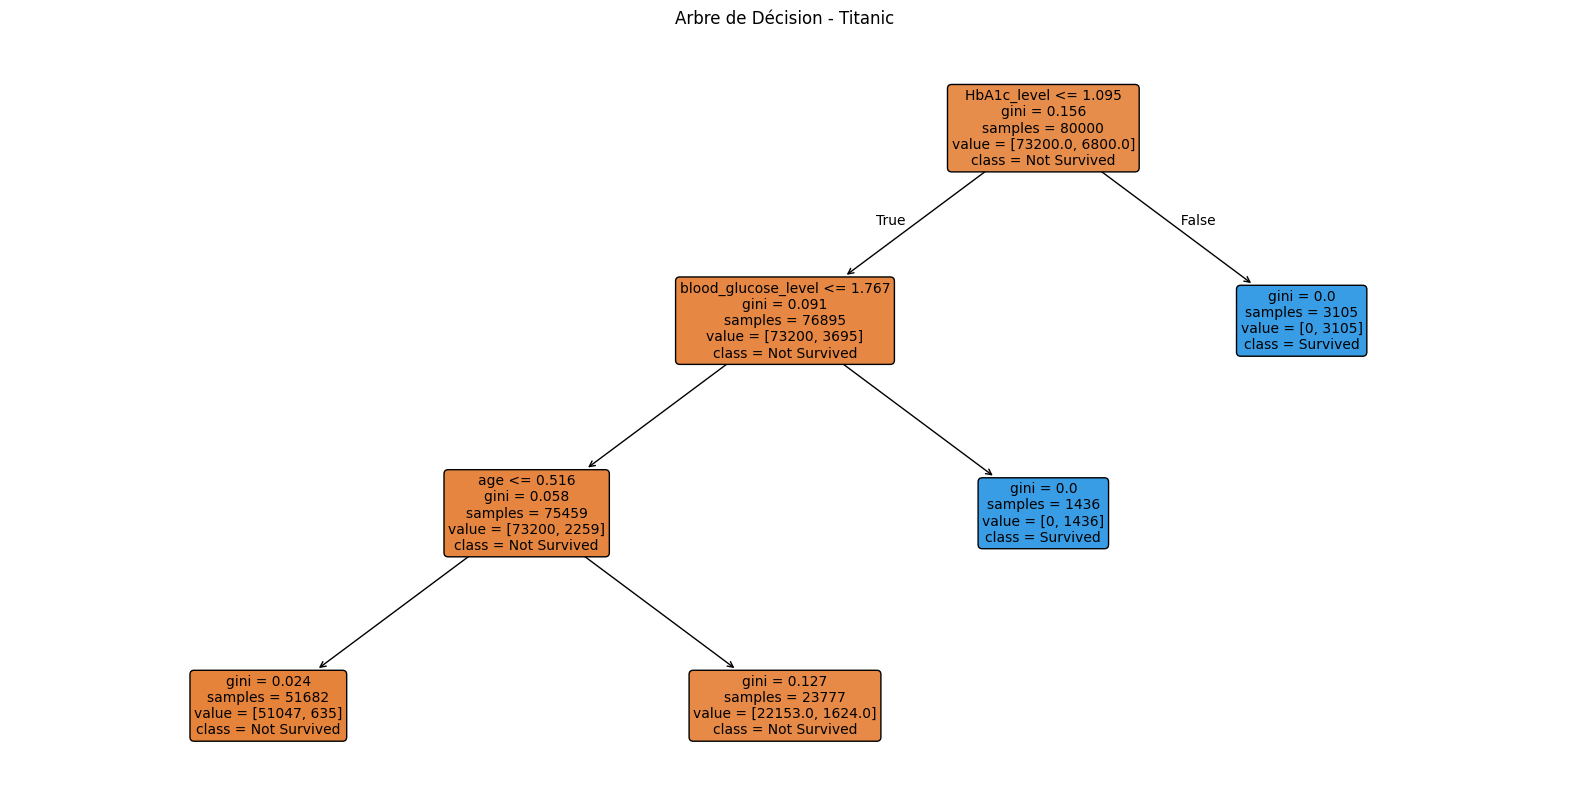

In [69]:
#afficher l'arbre de décision 
plt.figure(figsize=(20, 10))  
plot_tree(
    best_tree,                   
    feature_names=X.columns,     
    class_names=['Not Survived', 'Survived'],  
    filled=True,                 
    rounded=True,                
    fontsize=10
)
plt.title("Arbre de Décision - Titanic")
plt.show()

In [70]:
# extraire les importances des variables
importances = best_tree.feature_importances_

# creer une serie pandas pour lier à chaque nom de colonne
feat_importances = pd.Series(importances, index=X.columns)

# afficher les importances triées par ordre decroissant
print("Importance des variables :")
print(feat_importances.sort_values(ascending=False))


Importance des variables :
HbA1c_level            0.662601
blood_glucose_level    0.324881
age                    0.012518
gender                 0.000000
hypertension           0.000000
heart_disease          0.000000
smoking_history        0.000000
bmi                    0.000000
dtype: float64


In [71]:
# predire les classes des données de test
y_pred_tree = best_tree.predict(X_test)

best_tree_accuracy_score = accuracy_score(y_test, y_pred_tree)
best_tree_classification_report = classification_report(y_test, y_pred_tree)
best_tree_confusion_matrix = confusion_matrix(y_test, y_pred_tree)

# Évaluation
print("\n Decision Tree - Accuracy:", best_tree_accuracy_score)
print("\n Rapport de classification :\n", best_tree_classification_report)
print("\n Matrice de confusion :\n",best_tree_confusion_matrix)


 Decision Tree - Accuracy: 0.9723

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


 Matrice de confusion :
 [[18300     0]
 [  554  1146]]


<span style='color:red'>**Remarques globales** : </span></br>

- Très bonne performance globale avec une accuracy test de 97.23% et une validation croisée à 97.18%, indiquant pas d’overfitting.
- Arbre de profondeur faible (max_depth=3) : modèle simple, interprétable et bien régularisé.
- L’arbre repose quasiment uniquement sur HbA1c et glucose, ce qui le rend très interprétable.
- Toutefois, le recall de la classe diabétique (1) reste un point faible à surveiller (faux négatifs).

## Random Forest Classifier

C’est un ensemble d’arbres de décision.
Chaque arbre est entraîné sur un sous-échantillon aléatoire des données et vote pour prédire la classe.
Cela réduit le surapprentissage tout en gardant la flexibilité des arbres.

In [84]:
# deinir le modele de base 
rf_model = RandomForestClassifier(random_state=42)

# grille des hyperparamètres à tester
param_grid = {
    'n_estimators': [50, 100],        
    'max_depth': [4, 5,7],            
    'min_samples_split': [2, 5],           
    'min_samples_leaf': [1,2] ,            
}

# grid Search avec validation croisée 5 partitions
grid_search_rf = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 100]},
             scoring='accuracy')

In [85]:
# meilleurs paramètres
print("Meilleurs paramètres trouvés :")
print(grid_search_rf.best_params_)
print(f"Accuracy moyenne CV : {grid_search_rf.best_score_:.4f}")

Meilleurs paramètres trouvés :
{'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy moyenne CV : 0.9718


In [86]:
# entrainer le modele avec les meilleurs parametres 
best_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, n_estimators=50, random_state=42)

In [87]:
# l'importance des variables
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=False)

HbA1c_level            0.452974
blood_glucose_level    0.419246
age                    0.050438
bmi                    0.031934
hypertension           0.029577
heart_disease          0.011303
smoking_history        0.004341
gender                 0.000188
dtype: float64

In [88]:
# evaluation 
y_pred_rf = best_rf.predict(X_test)

best_rf_accuracy_score = accuracy_score(y_test, y_pred_rf)
best_rf_classification_report =  classification_report(y_test, y_pred_rf)
best_rf_confusion_matrix = confusion_matrix(y_test, y_pred_rf)
print("Random Forest - Accuracy:", best_rf_accuracy_score)
print("\nRapport de classification :\n", best_rf_classification_report)
print("\nMatrice de confusion :\n",best_rf_confusion_matrix)

Random Forest - Accuracy: 0.9723

Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.99     18300
           1       1.00      0.67      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.99      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


Matrice de confusion :
 [[18300     0]
 [  554  1146]]


<span style='color:red'>**Remarques globales** : </span></br>

- Très bonne performance globale avec une accuracy test de 97.23% et une validation croisée à 97.18%, indiquant pas d’overfitting. (même que l'arbre de décision)
- Paramètres choisis intelligemment (max_depth=4, n_estimators=50), le modèle équilibré entre complexité et performance.
- Le modele prend en compte plusieurs dimensions par rapport au Decision Tree (HbA1c_level (45.3%), blood_glucose_level (41.9%) et age, bmi, hypertension contribuent également mais faiblement.
- Pour les diabétiques, recall et F1-score sont identiques à celui de l’arbre de décision, et aussi même matrice de confusion.

## Réseau de Neurones simple avec Keras

Le modèle suivant est un **réseau de neurones artificiel simple** pour prédire la variable cible Survived du dataset Titanic.
Le modèle est construit en utilisant l’API **Sequential** de Keras et se compose des éléments suivants :

- Une **couche d'entrée** adaptée à la taille des données d'entrée **(Input(shape=...))**.
- Deux **couches cachées** entièrement connectées **(Dense)** avec respectivement 16 et 8 neurones, utilisant la fonction d'activation **ReLU** pour introduire de la non-linéarité.
- Une **couche de sortie** avec un seul neurone et une **activation sigmoïde**, produisant une probabilité de survie (valeur entre 0 et 1).

Le modèle est entraîné avec l'optimiseur **Adam**, une fonction de perte adaptée à la classification binaire **(binary_crossentropy)**, et l'indicateur de performance **accuracy**.

Paramètres d’entraînement : 

- **Époques** : 30 passes sur les données d'entraînement.
- **Taille de batch** : 16 échantillons par mise à jour des poids.
- **Validation** : 20% des données d’entraînement sont utilisées pour la validation interne.

In [89]:
# construction du modele
nn_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(16, activation='relu'), 
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [90]:
# compilation du modele
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [91]:
# entrainement du modele
history = nn_model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2, verbose=0)

In [92]:
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9721500277519226


In [93]:
y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")

nn_accuracy_score = accuracy_score(y_test, y_pred)
nn_classification_report = classification_report(y_test, y_pred)
nn_confusion_matrix = confusion_matrix(y_test, y_pred)

# Évaluation
print("\n Réseau de neurones simples - Accuracy:", nn_accuracy_score)
print("\n Rapport de classification :\n", nn_classification_report)
print("\n Matrice de confusion :\n",nn_confusion_matrix)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step

 Réseau de neurones simples - Accuracy: 0.97215

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.99      0.68      0.81      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000


 Matrice de confusion :
 [[18284    16]
 [  541  1159]]


#### **Architecture améliorée**
- **EarlyStopping** : évite le surapprentissage (arrête l'entraînement si val_loss ne s'améliore plus pendant 5 epochs).

- **BatchNormalization** : stabilise et accélère l’apprentissage.

- **Validation_split** : te permet de suivre les performances sur un sous-ensemble de tes données d'entraînement.

In [96]:
# Architecture du réseau avec normalisation
nn_model = Sequential([
    Input(shape=(X.shape[1],)),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dense(8, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

In [97]:
# Compilation du modèle
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
# Callback pour arrêter si la validation ne s'améliore plus
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [99]:
# Entraînement du modèle
history = nn_model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.8998 - loss: 0.2607 - val_accuracy: 0.9601 - val_loss: 0.1130
Epoch 2/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9579 - loss: 0.1233 - val_accuracy: 0.9634 - val_loss: 0.1059
Epoch 3/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9583 - loss: 0.1222 - val_accuracy: 0.9641 - val_loss: 0.1030
Epoch 4/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9605 - loss: 0.1136 - val_accuracy: 0.9626 - val_loss: 0.1041
Epoch 5/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9623 - loss: 0.1090 - val_accuracy: 0.9617 - val_loss: 0.1048
Epoch 6/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9628 - loss: 0.1074 - val_accuracy: 0.9622 - val_loss: 0.1021
Epoch 7/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9631 - loss: 0.1075 - val_accuracy: 0.9643 - val_loss: 0.0991
Epoch 8/100
4000/4000 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9650 - loss

In [100]:
loss, accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Accuracy: {accuracy}")

Accuracy: 0.972100019454956


In [102]:
y_pred = (nn_model.predict(X_test) > 0.5).astype("int32")

nn_accuracy_score = accuracy_score(y_test, y_pred)
nn_classification_report = classification_report(y_test, y_pred)
nn_confusion_matrix = confusion_matrix(y_test, y_pred)

# Évaluation
print("\n Réseau de neurones amélioré - Accuracy:", nn_accuracy_score)
print("\n Rapport de classification :\n", nn_classification_report)
print("\n Matrice de confusion :\n",nn_confusion_matrix)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  

 Réseau de neurones amélioré - Accuracy: 0.9721

 Rapport de classification :
               precision    recall  f1-score   support

           0       0.97      1.00      0.98     18300
           1       0.99      0.68      0.80      1700

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.89     20000
weighted avg       0.97      0.97      0.97     20000


 Matrice de confusion :
 [[18292     8]
 [  550  1150]]


<span style='color:red'>**Remarques globales** : </span></br>

- Les deux modèles ont des performances très proches, avec une accuracy stable à ~97.2%.*
- La classe 0 (non diabétique) est presque parfaitement détectée (recall = 1.00).
- Pour la classe 1 (diabétique) :
    - Le recall reste à 0.68 → environ 32% de faux négatifs (550 cas non détectés).
    - Le modèle amélioré réduit les faux positifs (8 au lieu de 16), mais augmente légèrement les faux négatifs (550 vs 541).
    - Légère baisse du F1-score en version améliorée, mais les deux scores restent bons (~0.80).

## <span style='color:brown'>**Conclusion générale** : </span></br>
- Le **Random Forest Classifier** et le **Réseau de Neurones** (simple et amélioré) atteignent tous deux une **accuracy de 97.2%**, avec des performances très proches.
- Cependant, **Random Forest** offre un meilleur équilibre entre **recall** et **précision** pour la classe minoritaire (diabète), ce qui en fait le **modèle le plus robuste** globalement.
- **Les modèles d’ensemble (Random Forest)** et **les réseaux de neurones** se sont révélés **plus stables** et **capables de mieux généraliser** que les modèles simples comme la **régression logistique** ou **KNN**.
-  **Limites et perspectives** : Le **déséquilibre de classes** impacte les performances de tous les modèles : malgré une bonne accuracy globale, le recall pour la classe diabétique reste moyen (~0.68).